In [1]:
from preprocessor import *

# Reading data 

In [2]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
df = pd.concat([train,test])

# Data Exploration

In [3]:
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [4]:
#We can observe that mean is almost nearer to 50%(median) for Income and Loan Amount attributes, which indicates Normal Distribution


In [5]:
train.shape

(614, 13)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.4+ KB


In [7]:
train['Property_Area'].value_counts()

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

In [8]:
train['Credit_History'].value_counts()

1.0    475
0.0     89
Name: Credit_History, dtype: int64

# Distribution of Variables

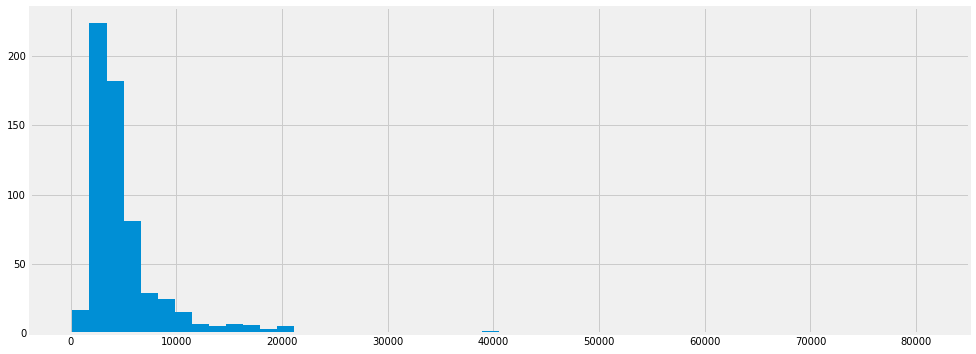

In [9]:
train['ApplicantIncome'].hist(bins=50,figsize=(15,6));

Mean and median lies around 3000-5000 but there are many outliers till 80,000

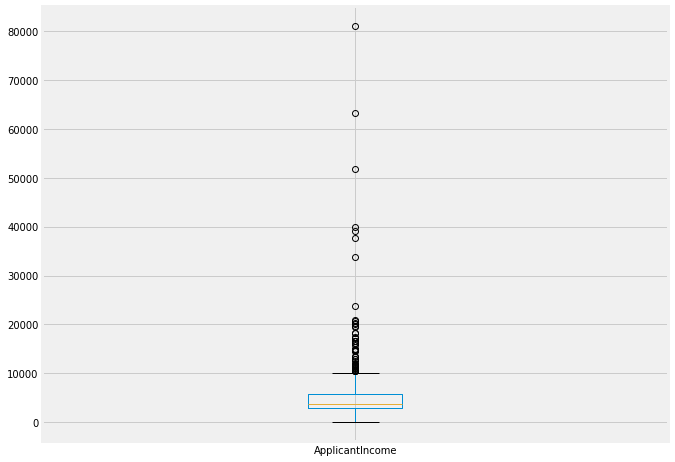

In [10]:
plt.figure(figsize=(10,8))
train.boxplot(column='ApplicantIncome');

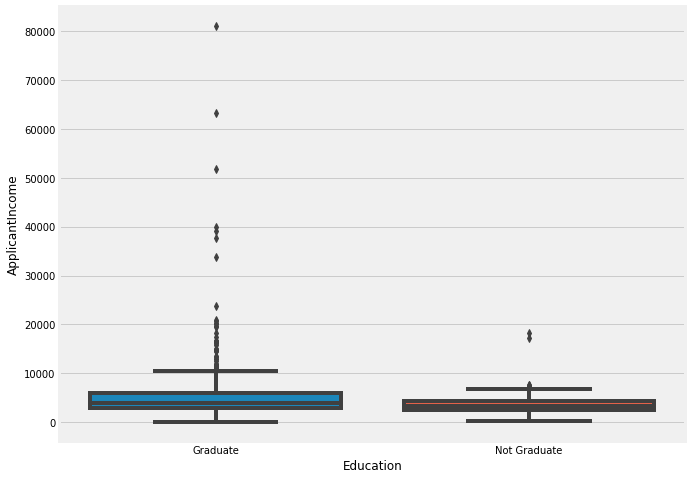

In [11]:
plt.figure(figsize=(10,8))
sns.boxplot("Education","ApplicantIncome",data = train );

Both Graduates and Non Graduates have almost same mean, but Graduates have more income disparities (outliers) which have to be removed 

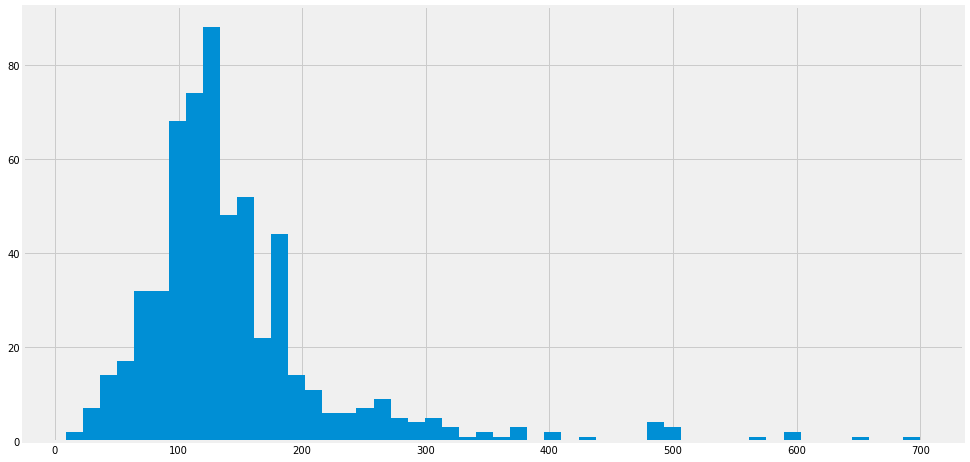

In [12]:
train['LoanAmount'].hist(bins=50,figsize=(15,8));

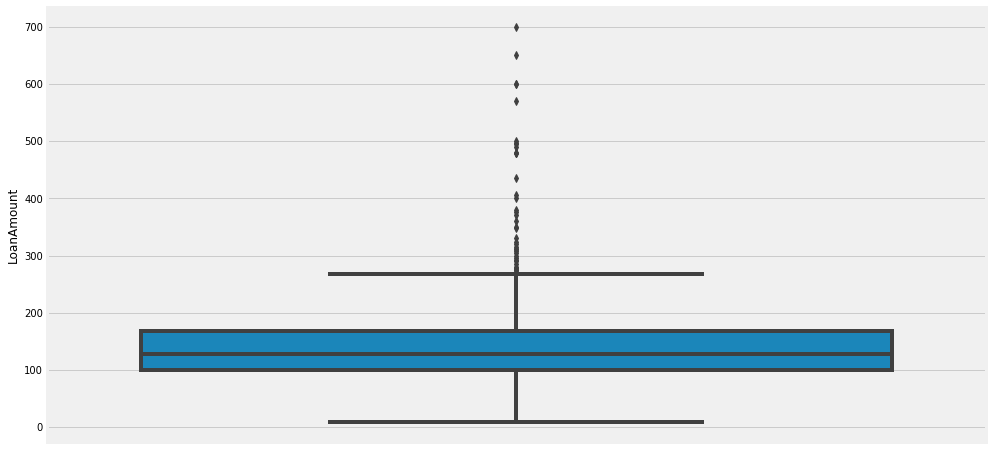

In [13]:
plt.figure(figsize=(15,8))
sns.boxplot(y="LoanAmount",data = train );

In [14]:
#Frequency table for Credit history
train['Credit_History'].value_counts(ascending=True)

0.0     89
1.0    475
Name: Credit_History, dtype: int64

In [15]:
#Probability of getting loan based on the credit history
pd.pivot_table(train,index='Credit_History',values='Loan_Status',aggfunc=lambda x: x.map({'Y':1, 'N':0}).mean())
#this shows that almost 80% of the applicants with good credit history has got the loan

,Loan_Status
Credit_History,
0.0,0.078652
1.0,0.795789


In [16]:
#probability of getting loan based on gender
pd.pivot_table(train,index='Gender',values='Loan_Status',aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())

#Almost men and women has a fair chance of loan acceptance, so Gender doesn't play an important role

,Loan_Status
Gender,
Female,0.669643
Male,0.693252


In [17]:
#probability of getting loan based on Marital stauts
pd.pivot_table(train,index=['Gender','Married'],values='Loan_Status',aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())

#Marital status also doesn't seem to have much effect on loan status, but there is a bit more chance of acceptance for married than unmarried

Loan_Status
Gender Married             
Female No          0.637500
       Yes         0.741935
Male   No          0.623077
       Yes         0.717087

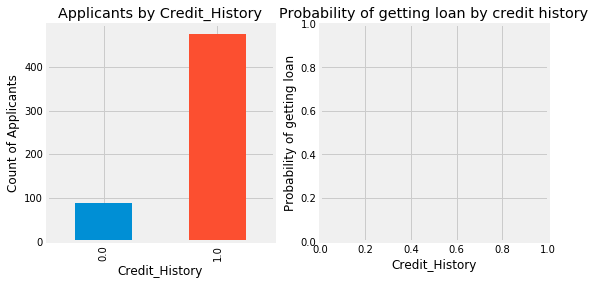

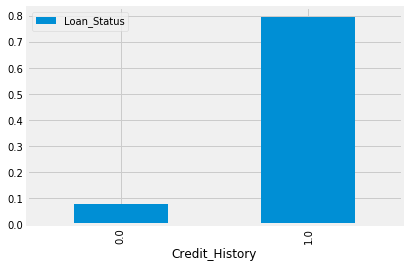

In [18]:
#we can also plot the same things in form of graphs
temp1 = train['Credit_History'].value_counts(ascending=True)
temp2 = train.pivot_table(values='Loan_Status',index=['Credit_History'],aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('Credit_History')
ax1.set_ylabel('Count of Applicants')
ax1.set_title("Applicants by Credit_History")
temp1.plot(kind='bar')

ax2 = fig.add_subplot(122)
temp2.plot(kind = 'bar')
ax2.set_xlabel('Credit_History')
ax2.set_ylabel('Probability of getting loan')
ax2.set_title("Probability of getting loan by credit history");

# Data Munging

In [19]:
#Finding the missing values in data
train.apply(lambda x: sum(x.isnull()),axis=0)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [20]:
#First let us fill all missing values of Gender,Married and Self_Employed columns with respective modes

train['Gender'].fillna('Male', inplace=True)
train['Married'].fillna('Yes', inplace=True)
train['Self_Employed'].fillna('No', inplace=True)

In [21]:
train.apply(lambda x: sum(x.isnull()),axis=0)

Loan_ID               0
Gender                0
Married               0
Dependents           15
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [22]:
#Now let us fill the missing values of LoanAmount
#Each index is made up with a combination of more than one value

impute_grps = train.pivot_table(values="LoanAmount",index=["Gender","Married","Self_Employed"],aggfunc=np.mean)

#iterate only through rows with missing LoanAmount
for i,row in train.loc[train['LoanAmount'].isnull(),:].iterrows():
  ind = tuple([row['Gender'],row['Married'],row['Self_Employed']])
  train.loc[i,'LoanAmount'] = impute_grps.loc[ind].values[0]

In [23]:
train.apply(lambda x: sum(x.isnull()),axis=0)

Loan_ID               0
Gender                0
Married               0
Dependents           15
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

# Missing value treatment

In [24]:
#Let us consider LoanAmount first
#As some people might apply for huge loans, let us not treat them as outliers and instead apply log transformation

train['LoanAmount_log'] = np.log(train['LoanAmount'])

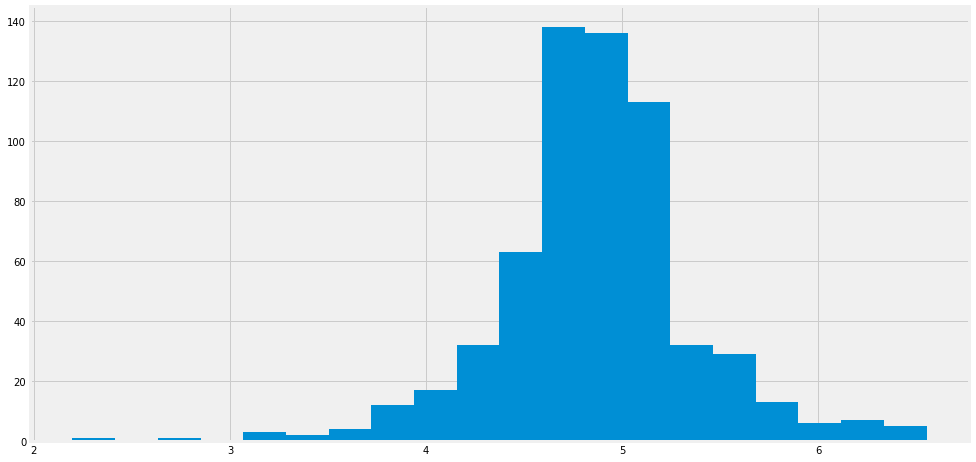

In [25]:
train['LoanAmount_log'].hist(bins=20,figsize=(15,8));

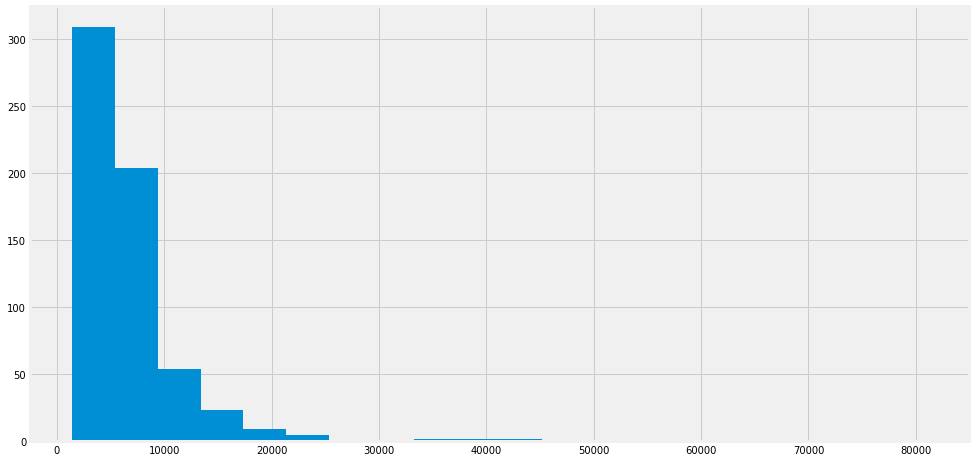

In [26]:
#Now let us consider Applicant INcome
#We can combine both Applicant Income and COapplicant income as Total income and apply log transformation

train['TotalIncome']=train['ApplicantIncome']+train['CoapplicantIncome']
train['TotalIncome'].hist(bins=20,figsize=(15,8));

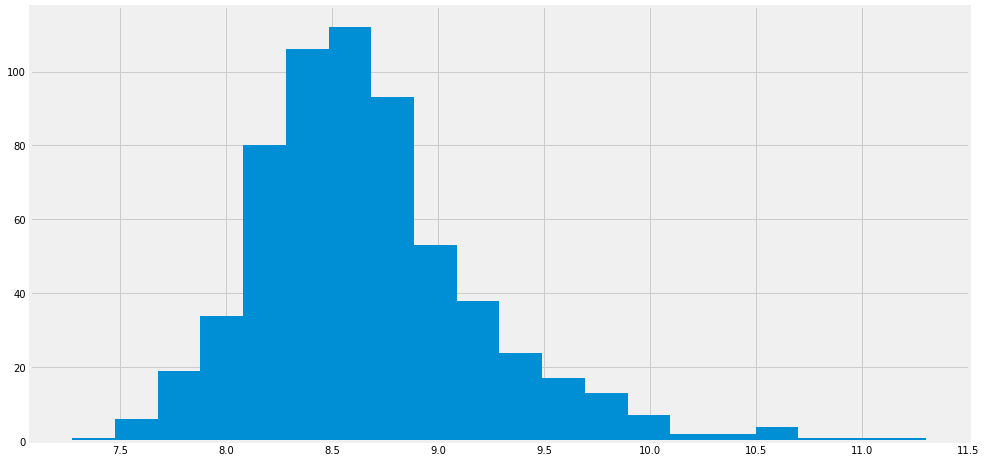

In [27]:
#Let us apply log transformation on the created variable - total income
train['TotalIncome_log']=np.log(train['TotalIncome'])
train['TotalIncome_log'].hist(bins=20,figsize=(15,8));

In [28]:
train['Credit_History'].value_counts()

1.0    475
0.0     89
Name: Credit_History, dtype: int64

In [29]:
train['Credit_History']=train['Credit_History'].fillna(1.0)

In [30]:
train['Credit_History'].value_counts()

1.0    525
0.0     89
Name: Credit_History, dtype: int64

In [31]:
train.isnull().sum()

Loan_ID               0
Gender                0
Married               0
Dependents           15
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     14
Credit_History        0
Property_Area         0
Loan_Status           0
LoanAmount_log        0
TotalIncome           0
TotalIncome_log       0
dtype: int64

In [32]:
#Finding the missing values in data
test.apply(lambda x: sum(x.isnull()),axis=0)

#First let us fill all missing values of Gender,Married and Self_Employed columns with respective modes

test['Gender'].fillna('Male', inplace=True)
test['Married'].fillna('Yes', inplace=True)
test['Self_Employed'].fillna('No', inplace=True)

#Now let us fill the missing values of LoanAmount
#Each index is made up with a combination of more than one value

impute_grps = test.pivot_table(values="LoanAmount",index=["Gender","Married","Self_Employed"],aggfunc=np.mean)

#iterate only through rows with missing LoanAmount
for i,row in test.loc[test['LoanAmount'].isnull(),:].iterrows():
  ind = tuple([row['Gender'],row['Married'],row['Self_Employed']])
  test.loc[i,'LoanAmount'] = impute_grps.loc[ind].values[0]

test.apply(lambda x: sum(x.isnull()),axis=0)

# Missing value treatment

#Let us consider LoanAmount first
#As some people might apply for huge loans, let us not treat them as outliers and instead apply log transformation

test['LoanAmount_log'] = np.log(test['LoanAmount'])

#Now let us consider Applicant INcome
#We can combine both Applicant Income and COapplicant income as Total income and apply log transformation

test['TotalIncome']=test['ApplicantIncome']+test['CoapplicantIncome']

#Let us apply log transformation on the created variable - total income
test['TotalIncome_log']=np.log(test['TotalIncome'])


test['Credit_History']=test['Credit_History'].fillna(1.0)


test.isnull().sum()

Loan_ID               0
Gender                0
Married               0
Dependents           10
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term      6
Credit_History        0
Property_Area         0
LoanAmount_log        0
TotalIncome           0
TotalIncome_log       0
dtype: int64

# Building the model

Since SKLEARN requires all the inputs to be numeric, we should convert all categorical variables into numeric

In [33]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanAmount_log,TotalIncome,TotalIncome_log
0,LP001002,Male,No,0,Graduate,No,5849,0.0,129.936937,360.0,1.0,Urban,Y,4.867049,5849.0,8.674026
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N,4.852030,6091.0,8.714568
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,4.189655,3000.0,8.006368
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y,4.787492,4941.0,8.505323
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,4.948760,6000.0,8.699515


In [34]:
from sklearn.preprocessing import LabelEncoder

In [35]:
var_mod = ['Gender','Married','Education','Self_Employed','Property_Area','Loan_Status']

for i in var_mod:
    train[i] = LabelEncoder().fit_transform(train[i])
train.dtypes

Loan_ID               object
Gender                 int64
Married                int64
Dependents            object
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int64
Loan_Status            int64
LoanAmount_log       float64
TotalIncome          float64
TotalIncome_log      float64
dtype: object

In [36]:
var_mod = ['Gender','Married','Education','Self_Employed','Property_Area']

for i in var_mod:
    test[i] = LabelEncoder().fit_transform(test[i])
train.dtypes

Loan_ID               object
Gender                 int64
Married                int64
Dependents            object
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int64
Loan_Status            int64
LoanAmount_log       float64
TotalIncome          float64
TotalIncome_log      float64
dtype: object

In [72]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanAmount_log,TotalIncome,TotalIncome_log
0,LP001002,1,0,0,0,0,5849,0.0,129.936937,360.0,1.0,2,1,4.867049,5849.0,8.674026
1,LP001003,1,1,1,0,0,4583,1508.0,128.000000,360.0,1.0,0,0,4.852030,6091.0,8.714568
2,LP001005,1,1,0,0,1,3000,0.0,66.000000,360.0,1.0,2,1,4.189655,3000.0,8.006368
3,LP001006,1,1,0,1,0,2583,2358.0,120.000000,360.0,1.0,2,1,4.787492,4941.0,8.505323
4,LP001008,1,0,0,0,0,6000,0.0,141.000000,360.0,1.0,2,1,4.948760,6000.0,8.699515


Importing the modules

In [91]:
#Import models from scikit learn module:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [92]:
#Generic function for making a classification model and accessing performance:
def classification_model(model, data, predictors, outcome):
  #Fit the model:
  model.fit(data[predictors],data[outcome])
  
  #Make predictions on training set:
  predictions = model.predict(data[predictors])
  
  #Print accuracy
  accuracy = metrics.accuracy_score(predictions,data[outcome])
  print("Accuracy : %s" % "{0:.3%}".format(accuracy))

  #Perform k-fold cross-validation with 5 folds
  kf = KFold( n_splits=5)
  error = []
  for train, test in kf.split(data):
    # Filter training data
    train_predictors = (data[predictors].iloc[train,:])
    
    # The target we're using to train the algorithm.
    train_target = data[outcome].iloc[train]
    
    # training the algorithm using the predictors and target.
    model.fit(train_predictors, train_target)
    
    #Record error from each cross-validation run
    error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
 
  print("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))

  #Fit the model again so that it can be refered outside the function:
  model.fit(data[predictors],data[outcome])

# Logistic Regression Model

In [93]:
#Let us try with 'Credit History' as input variable
target_var='Loan_Status'
input_var=['Credit_History']
model=LogisticRegression()
classification_model(model,train,input_var,target_var)

Accuracy : 80.945%
Cross-Validation Score : 80.946%


In [94]:
#We will give a set of input variables
input_var=['Gender','Married','Education','LoanAmount','Credit_History','TotalIncome']
classification_model(model,train,input_var,target_var)

Accuracy : 80.782%
Cross-Validation Score : 80.621%


We can clearly see that the Credit_History variable is dominating all other variables. 
Hence there is no increase in accuracy eventhough new variables are included.

In [95]:
model2=RandomForestClassifier()
classification_model(model2,train,input_var,target_var)

Accuracy : 98.208%
Cross-Validation Score : 72.476%


# On Test data 

In [96]:
reg = LogisticRegression()

In [97]:
input_var=['Gender','Married','Education','LoanAmount','Credit_History','TotalIncome']
reg.fit(train[input_var],train['Loan_Status'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [98]:
target_test = reg.predict(test[input_var])

In [99]:
test['Loan_Status']=target_test

In [100]:
test['Loan_Status']=test['Loan_Status'].map({1:'Y',0:'N'})

In [102]:
test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,LoanAmount_log,TotalIncome,TotalIncome_log,Loan_Status
0,LP001015,1,1,0,0,0,5720,0,110.0,360.0,1.0,2,4.700480,5720,8.651724,Y
1,LP001022,1,1,1,0,0,3076,1500,126.0,360.0,1.0,2,4.836282,4576,8.428581,Y
2,LP001031,1,1,2,0,0,5000,1800,208.0,360.0,1.0,2,5.337538,6800,8.824678,Y
3,LP001035,1,1,2,0,0,2340,2546,100.0,360.0,1.0,2,4.605170,4886,8.494129,Y
4,LP001051,1,0,0,1,0,3276,0,78.0,360.0,1.0,2,4.356709,3276,8.094378,Y


In [346]:
test[['Loan_ID','Loan_Status']].to_csv('submission1.csv')

In [347]:
dec = DecisionTreeClassifier()

In [103]:
rfor = RandomForestClassifier(n_estimators=100)

In [104]:
input_var = ['Gender', 'Married', 'Education',
       'Self_Employed', 'Credit_History', 'Property_Area',
        'LoanAmount_log','TotalIncome_log']
rfor.fit(train[input_var],train['Loan_Status'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [105]:
target_test = rfor.predict(test[input_var])

test['Loan_Status3']=target_test

test['Loan_Status3']=test['Loan_Status3'].map({1:'Y',0:'N'})

test[['Loan_ID','Loan_Status3']].to_csv('submission3.csv')